# WALLABY internal data access science

A notebook pre-filled with cells and scripts for querying the WALLABY internal release data via the public TAP interface. The notebook has the following sections

1. Setup
2. Source finding detection catalog
3. Use kinematic models

---

# 1. Setup 

In [1]:
import os
import tarfile
import requests
import getpass
import pyvo as vo
from pyvo.auth import authsession, securitymethods
from astropy.io.votable import from_table, parse_single_table

### Authenticate

<span style="font-weight: bold; color: #FF0000;">⚠ Update the cell below with your username and enter your password</span>

In [2]:
# Enter WALLABY user username and password

username = 'wallaby_user'
password = getpass.getpass('Enter your password')

Enter your password········


In [3]:
# Connect with TAP service

URL = "https://wallaby.aussrc.org/tap"
auth = vo.auth.AuthSession()
auth.add_security_method_for_url(URL, vo.auth.securitymethods.BASIC)
auth.credentials.set_password(username, password)
tap = vo.dal.TAPService(URL, session=auth)

# 2. Source finding

First we need to identify which internal release we want to access. The WALLABY team uses tags to classify source finding detections as internally released. You can view all of the tags by running the cells below. Then, we set the `tag_name` variable two cells below. This will be used later in the notebook, so once you know what data you would like to access, update this value accordingly.

In [4]:
# Get all tags

query = "SELECT * FROM wallaby.tag"
votable = tap.search(query)
table = votable.to_table()
table

id,name,description,added_at
int64,object,object,object
2,Norma DR1,Norma DR1 data release,2022-02-17T00:49:41.748948
3,NGC 5044 DR1,NGC 5044 DR1 data release,2022-02-17T05:20:01.326107
6,Hydra DR1,Hydra DR1 data release,2022-02-23T04:49:08.557440
7,Hydra DR2,Hydra DR2 data release,2022-02-23T04:49:22.070213
12,NGC 5044 DR3,NGC 5044 DR3 data release,2022-10-24T08:44:05.774250
10,NGC 5044 DR2,NGC 5044 DR2 data release,2022-06-10T08:55:44.842245
9,NGC 4808 DR1,NGC 4808 DR1 data release,2022-05-27T08:18:00.781334
8,NGC 4636 DR1,NGC 4636 DR1 data release,2022-02-23T04:49:39.754897
14,Internal Release,The source and corresponding detection have been released internally to the team.,2022-12-02T05:53:15.478050


As an example, let us retrieve all sources from phase 2 pilot observations released as part of the NGC 5044 DR1 release by supplying the `NGC 5044 DR1` tag to the `wallaby.get_catalog()` function:

<span style="font-weight: bold; color: #FF0000;">⚠ Update the `tag_name` value here</span>

In [5]:
# SELECT TAG

tag_name = "NGC 5044 DR1"

In [6]:
# Retrieve catalog as Astropy table

query = """SELECT d.*, ivo_string_agg(t.name || ': ' || t.description, '; ') AS tags, ivo_string_agg(c.comment, '; ') AS comments
        FROM wallaby.detection d
        LEFT JOIN wallaby.tag_detection td ON d.id = td.detection_id 
        LEFT JOIN wallaby.tag t ON t.id = td.tag_id
        LEFT JOIN wallaby.comment c ON d.id = c.detection_id
        WHERE t.name IN ('Internal Data Release', '$TAG_NAME')
        GROUP BY d.id"""
query = query.replace('$TAG_NAME', tag_name)
result = tap.search(query)
table = result.to_table()
table

id,name,run_id,instance_id,access_url,access_format,source_name,x,y,z,x_min,x_max,y_min,y_max,z_min,z_max,n_pix,f_min,f_max,f_sum,rel,flag,rms,w20,w50,ell_maj,ell_min,ell_pa,ell3s_maj,ell3s_min,ell3s_pa,kin_pa,err_x,err_y,err_z,err_f_sum,ra,dec,freq,l,b,v_rad,v_opt,v_app,tags,comments
,,,,,,,pix,pix,pix,pix,pix,pix,pix,pix,pix,,Jy / beam,Jy / beam,Hz Jy,,,Jy / beam,Hz,Hz,pix,pix,deg,pix,pix,deg,deg,pix,pix,pix,Hz Jy,deg,deg,Hz,deg,deg,m / s,m / s,m / s,,
int64,object,int64,int64,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object
4682,SoFiA J134432.82-244925.4,86,167,https://wallaby.aussrc.org/survey/vo/dl/dlmeta?ID=4682,application/x-votable+xml;content=datalink,WALLABY J134432-244925,892.2192722974343,828.6910794180917,5930.480420466962,584.0,605.0,516.0,539.0,722.0,762.0,5492.0,-0.008456071838736534,0.01184215117245913,4962.708632666648,0.9982983729971763,0,0.002604982655527896,575810.2416679957,425258.4382175294,8.044182715264228,5.801783566052931,-9.205918086063775,5.923879573502616,4.761718187956442,-17.19364722750088,137.7057788195698,0.2704957238534749,0.3529004099740369,0.6126948158876361,669.985827289204,206.1367425362275,-24.82372652760987,1405323711.490019,--,--,--,--,--,NGC 5044 DR1: NGC 5044 DR1 data release,
4683,SoFiA J134414.08-231547.6,86,167,https://wallaby.aussrc.org/survey/vo/dl/dlmeta?ID=4683,application/x-votable+xml;content=datalink,WALLABY J134414-231547,912.7966375267697,1765.380706387507,5850.886035304528,608.0,618.0,1459.0,1474.0,653.0,674.0,1570.0,-0.005550565663725138,0.005026679951697588,858.3479820249023,0.9670331513514654,0,0.002414710355013335,305803.3007435854,292091.9646533701,6.154688079922152,4.430776380504492,-20.44248192845933,0.0,0.0,0.0,-1.0,0.4981209955259176,0.6571609308369059,1.19492230125207,332.055276869292,206.0586737670744,-23.26321527118279,1403849741.39442,--,--,--,--,--,NGC 5044 DR1: NGC 5044 DR1 data release,
4686,SoFiA J134002.99-252831.1,86,167,https://wallaby.aussrc.org/survey/vo/dl/dlmeta?ID=4686,application/x-votable+xml;content=datalink,WALLABY J134002-252831,1510.219285286971,449.6839309740759,5450.948663002661,1197.0,1223.0,137.0,162.0,220.0,308.0,12088.0,-0.02482357807457447,0.03819903358817101,28043.9008702014,0.9999999975533298,0,0.007561451779130322,1379746.581870909,1197784.306285804,10.23336711287187,7.073002847152249,-55.90017703864724,11.33521688663817,10.16133348083117,83.44766682365,295.3845286580857,0.2678909318396133,0.2450701235191281,1.314342289480209,2885.213317420493,205.012446592053,-25.47530390468324,1396443493.759208,--,--,--,--,--,NGC 5044 DR1: NGC 5044 DR1 data release,
4689,SoFiA J134321.17-251560.0,86,167,https://wallaby.aussrc.org/survey/vo/dl/dlmeta?ID=4689,application/x-votable+xml;content=datalink,WALLABY J134321-251560,1060.552281782639,566.7393706726875,5375.146685287778,740.0,776.0,253.0,279.0,154.0,220.0,16399.0,-0.02024710923433304,0.02464260533452034,22517.83897053215,0.9999999999710679,0,0.005048318670086136,921515.8572879418,855012.4069108561,19.07482073732793,6.461294385356203,-75.48852433620664,19.82546843029606,4.674523655349004,-75.73354263673336,109.5109592769523,0.468515461222678,0.2205810563135068,0.767903659358751,2243.62856155457,205.8382038629939,-25.26665875033205,1395039753.431156,--,--,--,--,--,NGC 5044 DR1: NGC 5044 DR1 data release,
4690,SoFiA J134255.03-250726.7,86,167,https://wallaby.aussrc.org/survey/vo/dl/dlmeta?ID=4690,application/x-votable+xml;content=datalink,WALLABY J134255-250726,1117.6818226052126,653.3700870157163,5366.6332604437275,808.0,828.0,345.0,361.0,144.0,217.0,7509.0,-0.01123945042490959,0.01789263635873795,9954.584601798539,0.9999981425157802,0,0.00357455217083513,950721.5222104554,856088.9992852381,7.260116910795796,4.7019900

The source catalog returned by the function should have been printed above (if not, check for error messages) and is stored in the variable `table`. We can now use basic indexing to access different catalog entries. For example, `table["f_sum"]` will return the entire column of integrated flux measurements, and we can use `table["f_sum"][0]` etc. to extract the individual fluxes for each source. Likewise, `table[0]` will extract the entire first row of the catalog, i.e. a list of all parameters of the first source.

## Calculate Physical Parameters

The next example demonstrates how to retrieve certain parameters from the catalog and use basic arithmetic to convert some of the raw measurements made by SoFiA into physically meaningful parameters such as redshift or HI mass. These can be directly appended to the catalog as additional columns using `table["parameter_name"] = <expression>`.

In [7]:
import numpy as np
import scipy.constants as const
from astropy.cosmology import FlatLambdaCDM

# Set up cosmology
f_rest = 1.42040575e+9;  # HI rest frequency in Hz
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)

# Calculate redshift
table["redshift"] = f_rest / table["freq"] - 1.0

# Calculate luminosity distance in Mpc and HI mass in solar masses
table["dl"] = cosmo.luminosity_distance(table["redshift"]).value
table["log_mhi"] = np.log10(49.7 * table["dl"] * table["dl"] * table["f_sum"])

# Calculate source rest frame velocity width in km/s
table["dv"] = const.c * (1.0 + table["redshift"]) * table["w20"] / f_rest / 1000.0

# Show our new parameters
table["name", "id", "redshift", "dl", "log_mhi", "dv"].pprint(max_width=-1)

           name            id         redshift               dl              log_mhi               dv        
------------------------- ---- --------------------- ------------------ ------------------ ------------------
SoFiA J134432.82-244925.4 4682  0.010732074316165852 46.343582538744066  8.724054373463328  122.8354480037879
SoFiA J134414.08-231547.6 4683  0.011793291060576916  50.96736693994223  8.044604174753959  65.30437018378547
SoFiA J134002.99-252831.1 4686  0.017159488620829055   74.4610715890404  9.888053375977352 296.20791750239096
SoFiA J134321.17-251560.0 4689  0.018182991922958136  78.96340605957987  9.843734844236277 198.03271072587592
SoFiA J134255.03-250726.7 4690   0.01829807166624753  79.47006211034552  9.494786635540121 204.33206687867394
SoFiA J133836.10-202908.7 4693 0.0021970654600744766   9.42548834630763   7.54975272452531  49.10909952078591
SoFiA J134247.87-193454.0 4695  0.004724270007723019 20.306811525563226   8.39642966178716  63.78226616342829
SoFiA J134

## Create a Plot

Once we’ve done our analysis, we can the create plots of any of the parameters in our table. In this example, let us plot the logarithmic HI mass against redshift and additionally colour the data points by source rest frame velocity width. If desired, the resulting plot can be exported as a PDF file and then downloaded to your local computer, e.g. to use in a presentation or publication.

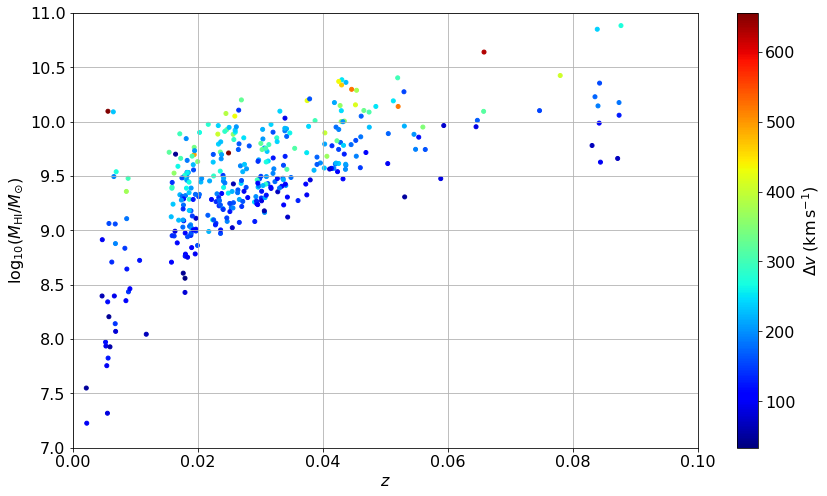

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (14, 8)
plt.rcParams["font.size"] = 16

plt.scatter(table["redshift"], table["log_mhi"], s=16, c=table["dv"], cmap="jet")
plt.xlabel(r"$z$")
plt.ylabel(r"$\log_{10}(M_{\rm HI} / M_{\odot})$")
cbar = plt.colorbar()
cbar.set_label(r"$\Delta v \; (\mathrm{km \, s}^{-1})$")
plt.xlim(0.0, 0.1)
plt.ylim(7.0, 11.0)
plt.grid(True)

# Uncomment the following line to make a PDF copy in the notebook folder for download
#plt.savefig("my_plot.pdf", format="pdf", bbox_inches="tight", pad_inches=0.05)

plt.show()

## Filtering the catalog

Once we have the catalog loaded into an Astropy table object, we can easily make selections to suit our scientific needs. The following examples illustrate how the catalog can be filtered by certain criteria such as parameter ranges or the presence of comments and tags.

**Example: Filter sources by parameter range**

In [9]:
# Select all sources within a certain RA and Dec range

mask = (table["ra"] > 202.0) & (table["ra"] < 203.0) & (table["dec"] > -22.5) & (table["dec"] < -21.5)
table[mask].pprint()

 id             name           run_id instance_id                       access_url                       ... comments       redshift               dl              log_mhi               dv        
                                                                                                         ...                                                                                       
---- ------------------------- ------ ----------- ------------------------------------------------------ ... -------- -------------------- ------------------ ------------------ ------------------
4882 SoFiA J133004.38-221319.7     86         173 https://wallaby.aussrc.org/survey/vo/dl/dlmeta?ID=4882 ...          0.017170015288004103  74.50734308323227  9.327531184300208  222.1068759056618
5244 SoFiA J133110.22-221104.3     86         207 https://wallaby.aussrc.org/survey/vo/dl/dlmeta?ID=5244 ...           0.05132598465170357 228.40091169549973 10.191099429675704 250.01565906691772
5570 SoFiA J133019.1

## Plot detection products

To view the products (moment maps, spectra, etc.) for a given detection you will need to authenticate with the AusSRC. For those who do not have an account with the AusSRC please first contact:

* Lachlan Campbell (lachlan.campbell@csiro.au)
* Hasan Rayan (hasan.rayan@csiro.au)

to have one set up for them. Once you have an account, you will need to log in to the portal at https://wallaby.aussrc.org to have your credentials synced. Then you will be able to run this section of the notebook.

In [10]:
# useful function for downloading table products (requires authentication)

def download_products(row, products_filename, chunk_size=8192):
    """Download products for a row of the table (a detection entry)
    
    """
    name = row['source_name']
    access_url = row['access_url']
    votable = parse_single_table(access_url)
    product_table = votable.to_table()
    url = product_table[product_table['description'] == 'SoFiA-2 Detection Products'][0]['access_url']
    with requests.get(url, auth=(username, password), stream=True) as r:
        r.raise_for_status()
        with open(products_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=chunk_size):
                f.write(chunk)
    print(f'Downloaded completed for {name}')
    return

def download_table_products(table, directory, chunk_size=8192):
    """Download WALLABY products from ADQL queried table

    """
    if not os.path.exists(directory):
        os.mkdir(directory)
    print(f'Saving products to {directory}')
    for row in table:
        name = row['source_name']
        products_filename = os.path.join(directory, f'{name}.tar')
        download_products(row, products_filename, chunk_size)
    print('Downloads complete')
    return

In [11]:
# Select detection of interest and download product files

detection_row = table[0]
name = detection_row['source_name']
products_filename = f'{name}.tar'
download_products(detection_row, products_filename)

Downloaded completed for WALLABY J134432-244925


In [12]:
# Check filesystem for file

assert os.path.exists(products_filename), 'Download error'
tf = tarfile.open(products_filename)
tf.extractall(name)
tf.close()

In [13]:
!ls '{name}'

NGC5044_4_167_SoFiA_J134432.82-244925.4_chan.fits
NGC5044_4_167_SoFiA_J134432.82-244925.4_cube.fits
NGC5044_4_167_SoFiA_J134432.82-244925.4_mask.fits
NGC5044_4_167_SoFiA_J134432.82-244925.4_mom0.fits
NGC5044_4_167_SoFiA_J134432.82-244925.4_mom1.fits
NGC5044_4_167_SoFiA_J134432.82-244925.4_mom2.fits
NGC5044_4_167_SoFiA_J134432.82-244925.4_plot.png
NGC5044_4_167_SoFiA_J134432.82-244925.4_spec.txt


### Create plots

Once we have the product files for the detection of interest, we can plot them using familiar Python libraries. In the example below, we will plot the moment 0 map of a detection of interest.

In [14]:
import glob 
from astropy.wcs import WCS
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

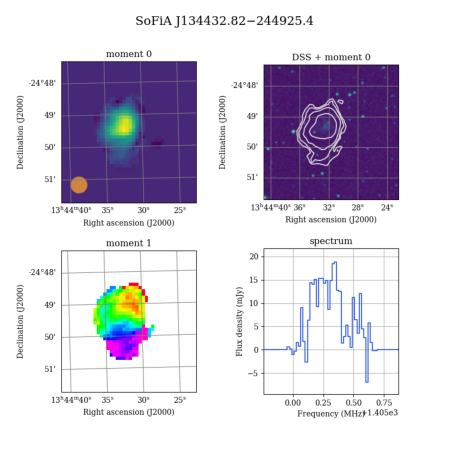

In [15]:
# plot summary figure

files = glob.glob(os.path.join(name, '*plot.png'))
file = files[0]
img = mpimg.imread(file)

plt.imshow(img) 
plt.axis('off')
plt.show()

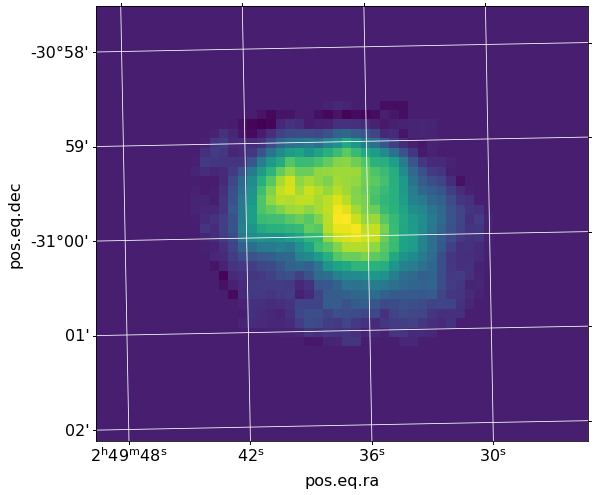

In [16]:
# open moment 0 map and plot

files = glob.glob(os.path.join(name, '*mom0.fits'))
file = files[0]
hdu = fits.open(file)[0]
wcs = WCS(hdu.header)

plt.subplot(projection=wcs) 
plt.imshow(hdu.data, origin='lower') 
plt.grid(color='white', ls='solid')
plt.show()

# 3. Kinematic models

<span style="font-weight: bold; color: #FF0000;">⚠ To be updated</span>

Kinematic models are now available through the WALLABY database. Only a subset of the sources have kinematic models. They can be accessed in a similar way to source products. First, we list the tags with `wallaby.get_kinematic_model_tags()`. Then, we use the tag to retrieve the catalog as an Astropy table with `wallaby.get_kinematic_model()`.

The kinematic model tags use the convention `TR` for "team release" and have the "Kin" keyword, whereas the source finding models use `DR` for "data release". To retrieve the kinematic models associated with NGC 5044 DR2, you would select the kinematic model tag "NGC 5044 Kin TR2".

In [17]:
# Select the list of available team release tags

query = """SELECT DISTINCT team_release_kin
        FROM wallaby.kinematic_model"""
result = tap.search(query)
result

<Table length=12>
     team_release_kin    
          object         
-------------------------
          NGC5044 Kin TR3
         NGC 5044 Kin TR2
         NGC 5044 Kin TR1
            Hydra Kin TR1
    Vela High-Res Kin TR1
            Hydra Kin TR2
NGC 4808 High-Res Kin TR1
            Norma Kin TR1
         NGC 4636 Kin TR1
             Vela Kin TR1
NGC 5044 High-Res Kin TR1
         NGC 4808 Kin TR1

In [18]:
# Set the kinematic tag desired
kin_tag = "NGC5044 Kin TR3"

# The generic query
query = """SELECT * FROM wallaby.kinematic_model k
        WHERE k.team_release_kin IN ('$TAG_NAME')"""
query = query.replace('$TAG_NAME', kin_tag)

# Run the tap query
result = tap.search(query)

# Get the resulting table
kin_table = result.to_table()

# Print off the table
kin_table

id,name,ra,dec,freq,team_release,team_release_kin,vsys_model,e_vsys_model,x_model,e_x_model,y_model,e_y_model,ra_model,e_ra_model,dec_model,e_dec_model,inc_model,e_inc_model,pa_model,e_pa_model,pa_model_g,e_pa_model_g,qflag_model,rad,vrot_model,e_vrot_model,e_vrot_model_inc,rad_sd,sd_model,e_sd_model,sd_fo_model,e_sd_fo_model_inc,r_hi,v_disp,v_rhi,kinver
,,deg,deg,Hz,,,km / s,km / s,pix,pix,pix,pix,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,,arcsec,km / s,km / s,km / s,arcsec,msol / pc2,msol / pc2,msol / pc2,msol / pc2,arcsec,km / s,km / s,
int64,object,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,object,object,object,object,object,object,object,object,object,float64,float64,float64,object
284,WALLABY J133756-240727,204.4868996317963,-24.12435097478599,1378414644.331974,NGC5044 TR3,NGC5044 Kin TR3,9127.6,1.9,22.165,0.4272,21.119,0.3732,204.48578,0.000789,-24.124762,0.000614,46.5,8.0,249.3,1.4,248.6,1.4,0,"7.5,22.56,37.62,52.68","126.0,127.7,120.7,114.5","35.3,0.2,2.4,4.6","17.3,17.6,16.6,15.7","7.5,22.56,37.62,52.68,67.74","2.79,2.58,1.95,1.23,0.5","0.3,0.35,0.32,0.25,0.21","1.917,1.774,1.343,0.844,0.344","0.282,0.261,0.198,0.124,0.051",0.0,0.0,0.0,WKAPPv1
240,WALLABY J134019-235122,205.082692315635,-23.85631890730078,1390219653.151989,NGC5044 TR3,NGC5044 Kin TR3,6503.7,0.8,28.22,0.8281,24.194,0.3766,205.080261,0.001521,-23.858877,0.000606,34.5,5.0,320.4,2.9,319.4,2.9,0,"7.5,22.56,37.62,52.68,67.74","224.3,234.8,233.0,226.1,216.1","34.6,3.6,0.3,2.1,9.1","29.3,30.7,30.4,29.6,28.2","7.5,22.56,37.62,52.68,67.74,82.8,97.86","3.48,4.69,4.73,2.77,1.14,0.39,0.16","0.75,0.73,0.47,0.53,0.43,0.2,0.1","2.868,3.868,3.899,2.284,0.944,0.32,0.13","0.172,0.232,0.234,0.137,0.057,0.019,0.008",0.0,0.0,0.0,WKAPPv1
257,WALLABY J133949-220132,204.9584213559631,-22.02556413308159,1393281191.641094,NGC5044 TR3,NGC5044 Kin TR3,5839.8,0.3,23.468,0.005,22.214,0.3126,204.958787,1.7e-05,-22.025207,0.000521,67.5,13.1,56.1,0.2,55.3,0.2,0,"7.5,22.56,37.62,52.68","150.4,152.8,159.9,148.1","27.4,0.1,3.4,0.3","15.0,15.3,16.0,14.8","7.5,22.56,37.62,52.68,67.74,82.8","15.16,11.55,7.3,3.61,1.41,0.48","0.75,2.09,2.18,1.36,0.75,0.35","5.799,4.418,2.794,1.382,0.538,0.184","3.177,2.421,1.531,0.757,0.295,0.101",0.0,0.0,0.0,WKAPPv1
261,WALLABY J133801-225524,204.5061192555524,-22.92373544526665,1388138632.877786,NGC5044 TR3,NGC5044 Kin TR3,6970.7,6.9,30.049,0.9492,23.329,0.4028,204.503015,0.001727,-22.92397,0.000653,69.2,1.2,250.5,3.2,249.8,3.2,0,"7.5,22.56,37.62,52.68","193.5,183.5,202.0,198.5","18.9,13.7,8.8,10.0","1.5,1.4,1.6,1.6","7.5,22.56,37.62,52.68,67.74,82.8,97.86","5.94,5.71,4.42,2.97,1.99,1.24,0.83","0.41,0.65,0.95,0.82,0.67,0.53,0.42","2.111,2.029,1.57,1.054,0.707,0.441,0.294","0.114,0.11,0.085,0.057,0.038,0.024,0.016",0.0,0.0,0.0,WKAPPv1
233,WALLABY J133541-240428,203.9234381893391,-24.07585148829603,1408377751.754337,NGC5044 TR3,NGC5044 Kin TR3,2558.9,17.4,24.936,0.56,23.968,0.3729,203.923112,0.001028,-24.074926,0.000615,81.7,8.3,318.7,0.7,318.2,0.7,3,"7.5,22.56,37.62,52.68,67.74","98.9,132.6,130.4,137.0,137.9","40.1,0.6,14.3,14.0,16.9","2.2,2.9,2.8,3.0,3.0","7.5,22.56,37.62,52.68,67.74,82.8,97.86","17.32,15.58,14.03,11.92,7.61,6.85,3.48","0.46,1.32,1.57,2.57,3.83,3.9,3.58","2.515,2.262,2.037,1.73,1.104,0.994,0.505","2.488,2.237,2.015,1.712,1.093,0.984,0.499",0.0,0.0,0.0,WKAPPv1
269,WALLABY J133440-234722,203.6672049819966,-23.78948427016499,1384388627.877617,NGC5044 TR3,NGC5044 Kin TR3,7805.9,0.0,25.417,1.0018,25.393,0.1495,203.664651,0.001827,-23.789085,0.000239,28.1,2.5,194.0,3.0,193.6,3.0,0,"7.5,22.56,37.62,52.68","114.0,175.2,187.1,175.2","73.9,3.1,6.1,15.7","9.4,14.5,15.5,14.5","7.5,22.56,37.62,52.68,67.74,82.8","3.06,3.26,2.42,1.41,0.68,0.29","0.49,0.41,0.35,0.27,0.18,0.12","2.698,2.876,2.13,1.244,0.596,0.26","0.063,0.067,0.05,0.029,0.014,0.006",0.0,0.0,0.0,WKAPPv1
249,WALLABY J133439-234044,203.663363474842,-23.6791483759322,1

We can then use the kinematic model table in the same way as the source finding table. Below is an example figure created from the kinematic model catalog.

The profiles in the kinematic tables are stored as strings, so these will need to be parsed into arrays.  The function below is designed to do this.

In [19]:
import numpy as np

def StrToArr(StrArr):
    StrVals = StrArr.split(",")
    FloatArr = np.zeros(len(StrVals))
    for i in range(len(StrVals)):
        FloatArr[i] = float(StrVals[i])
    return FloatArr

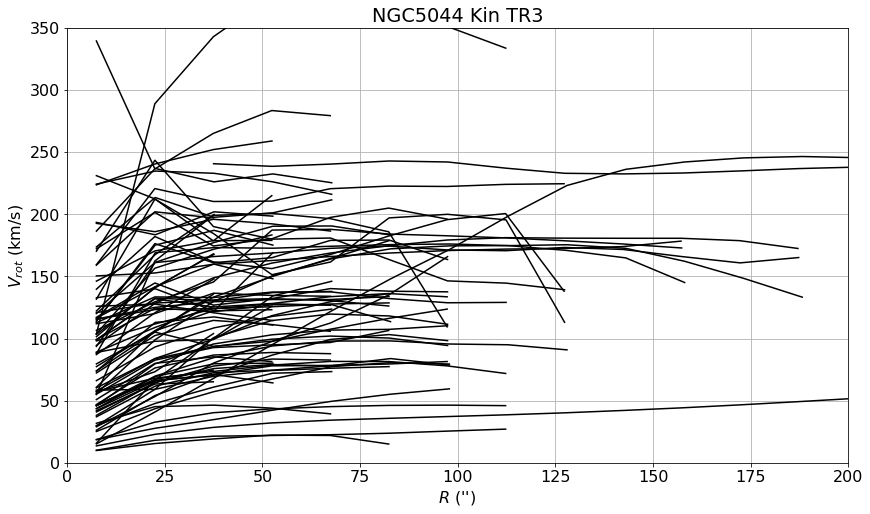

In [20]:
%matplotlib inline

#To make the plot look a bit nicer, we'll set the figure size and font size
plt.rcParams["figure.figsize"] = (14, 8)
plt.rcParams["font.size"] = 16

for row in kin_table:
    r = StrToArr(row['rad'])
    v = StrToArr(row['vrot_model'])
    plt.plot(r, v, ls='-', color='k', marker='')
    
plt.title(kin_tag)
plt.xlabel(r"$R$ ('') ")
plt.ylabel(r"$V_{rot}$ (km/s)")
plt.xlim(0.0, 200)
plt.ylim(0, 350)
plt.grid(True)
plt.show()

The kinematic_model table points to the WKAPP models.  These only include the pilot fields.  For the 3KIDNAS models, we need to point to the kinematic_model_3kidnas table.  This will include all internally released kinematic models for the full survey

In [21]:
# Select the list of available team release tags

query = """SELECT DISTINCT team_release_kin
        FROM wallaby.kinematic_model_3kidnas """
result = tap.search(query)
result

<Table length=10>
 team_release_kin
      object     
-----------------
NGC 5044 E KinTR1
   Norma E KinTR1
NGC 4808 E KinTR1
      Vela E KinT
NGC 5044 E KinTR2
   Hydra E KinTR2
NGC 5044 E KinTR3
    Vela E KinTR1
   Hydra E KinTR1
NGC 4636 E KinTR1

In [22]:
kin_tag = "NGC 5044 E KinTR3"

# The generic query
query= """SELECT d.source_name, k.*
        FROM wallaby.kinematic_model_3kidnas k
        LEFT JOIN wallaby.detection d ON k.detection_id = d.id
        WHERE k.team_release_kin IN ('$TAG_NAME')"""
query = query.replace('$TAG_NAME', kin_tag)

# Run the tap query
result = tap.search(query)

# Get the resulting table
kin_table_3kidnas = result.to_table()

# Print off the table
kin_table_3kidnas

source_name,id,detection_id,team_release,team_release_kin,vsys_model,e_vsys_model,x_model,e_x_model,y_model,e_y_model,ra_model,e_ra_model,dec_model,e_dec_model,inc_model,e_inc_model,pa_model,e_pa_model,pa_model_g,e_pa_model_g,vdisp_model,e_vdisp_model,rad,vrot_model,e_vrot_model,rad_sd,sd_model,e_sd_model,sdmethodflag,rhi_flag,rhi_as,rhi_low_as,rhi_high_as,dist_model,rhi_kpc,rhi_low_kpc,rhi_high_kpc,vhi_flag,vhi,e_vhi,kflag,kinver
,,,,,km / s,km / s,pix,pix,pix,pix,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,km / s,km / s,arcsec,km / s,km / s,arcsec,msol / pc2,msol / pc2,,,arcsec,arcsec,arcsec,arcsec,kpc,kpc,kpc,,km / s,km / s,,
object,int64,int64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,int32,int32,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,int32,object
WALLABY J130618-173039,312,7034,NGC 5044 DR3,NGC 5044 E KinTR3,1470.1,0.6,32.41,0.1802,28.08,0.1327,196.576722,0.000312,-17.511683,0.000221,43.3,3.9,297.1,1.7,296.1,1.7,9.6,0.9,"[7.48, 22.45, 37.42, 52.39, 67.35, 82.32]","[38.0, 30.4, 34.2, 51.5, 53.8, 52.0]","[13.6, 15.6, 8.1, 6.1, 4.2, 7.3]","[7.48, 22.45, 37.42, 52.39, 67.35, 82.32]","[9.2, 6.6, 4.9, 4.1, 3.4, 2.6]","[0.77, 0.89, 0.99, 0.64, 0.42, 0.42]",0,-1,--,--,--,21.00142857142857,--,--,--,-1,--,--,0,3KIDNAS V1
WALLABY J131305-195830,313,7172,NGC 5044 DR3,NGC 5044 E KinTR3,2757.8,1.2,22.3,0.0532,35.29,0.123,198.27106,9.5e-05,-19.976592,0.000205,81.2,1.3,359.7,0.5,359.2,0.5,13.2,4.2,"[7.48, 22.45, 37.42, 52.39, 67.35, 82.32, 97.29, 112.25]","[132.2, 167.5, 131.2, 140.1, 138.9, 150.6, 147.0, 144.2]","[16.5, 49.1, 18.7, 8.8, 10.4, 6.2, 7.3, 11.8]","[7.48, 22.45, 37.42, 52.39, 67.35, 82.32, 97.29, 112.25]","[9.1, 8.0, 6.1, 5.6, 3.5, 2.8, 1.6, 1.5]","[0.75, 1.32, 0.82, 0.84, 0.62, 0.61, 0.93, 0.55]",0,-1,--,--,--,39.39714285714286,--,--,--,-1,--,--,0,3KIDNAS V1
WALLABY J131321-185558,314,7188,NGC 5044 DR3,NGC 5044 E KinTR3,6149.7,1.4,20.77,0.1266,24.9,0.1158,198.339784,0.000224,-18.931458,0.000193,66.5,6.7,7.3,4.2,7.3,4.2,12.9,3.8,"[7.48, 22.45, 37.42, 52.39]","[48.5, 107.9, 120.9, 119.0]","[60.8, 11.8, 6.6, 14.6]","[7.48, 22.45, 37.42, 52.39]","[1.2, 4.7, 4.0, 1.4]","[4.92, 0.46, 0.93, 0.24]",0,-1,--,--,--,87.85285714285715,--,--,--,-1,--,--,0,3KIDNAS V1
WALLABY J130936-185815,315,7201,NGC 5044 DR3,NGC 5044 E KinTR3,10659.1,4.4,22.18,0.194,16.27,0.2138,197.399906,0.000344,-18.971577,0.000356,68.0,6.9,195.1,4.9,195.8,4.9,11.3,3.8,"[7.48, 22.45, 37.42, 52.39]","[150.3, 208.1, 179.8, 175.6]","[47.1, 24.0, 34.3, 20.4]","[7.48, 22.45, 37.42, 52.39]","[1.7, 5.0, 3.4, 0.72]","[3.13, 1.56, 1.06, 0.48]",0,-1,52.39,--,--,152.2728571428571,38.68,--,--,-1,--,--,0,3KIDNAS V1
WALLABY J131117-194944,316,7206,NGC 5044 DR3,NGC 5044 E KinTR3,2777.4,1.6,21.34,0.1305,19.62,0.1522,197.825054,0.000231,-19.828288,0.000254,79.5,19.6,123.6,2.5,121.8,2.5,8.7,1.6,"[7.48, 22.45, 37.42]","[64.7, 82.4, 81.6]","[16.6, 9.2, 13.0]","[7.48, 22.45, 37.42]","[1.9, 3.6, 2.8]","[2.6, 0.51, 0.54]",0,-1,--,--,--,39.67714285714286,--,--,--,-1,--,--,1,3KIDNAS V1
WALLABY J131430-173154,317,7213,NGC 5044 DR3,NGC 5044 E KinTR3,2472.9,10.6,21.9,0.3891,24.36,0.6423,198.626261,0.000691,-17.531793,0.001065,82.1,22.2,153.4,3.4,151.8,3.4,8.2,3.1,"[7.48, 22.45, 37.42, 52.39]","[80.0, 82.6, 113.2, 78.2]","[22.7, 26.0, 39.4, 48.4]","[7.48, 22.45, 37.42, 52.39]","[2.6, 2.5, 2.5, 0.69]","[2.46, 0.95, 1.13, 0.8]",0,0,52.39,43.24,61.54,35.32714285714286,8.97,7.4,10.54,0,84.19,41.76,0,3KIDNAS V1
WALLABY J131712-171511,318,7252,NGC 5044 DR3,NGC 5044 E KinTR3,2519.0,0.8,24.85,0.1107,25.27,0.1851,199.301443,0.000193,-17.253474,0.000308,54.6,3.2,228.9,1.6,229.5,1.6,7.1,1.3,"[7.48, 22.45, 37.42, 52.39, 67.35]","[86.8, 129.5, 135.9, 127.6, 115.3]","[47.7, 8.0, 4.9, 5.1, 8.1]","[7.48, 22.45, 37.42, 52.39, 67.35]","[3.2, 3.4, 2.6, 2.5, 1.3]","[1.15, 0.59, 0.5, 0.44, 0.27]",0,-1,--,--,--,35.985714285714

Once again we can make a plot of these models following the same approach as before. However, the strings include square brackets that need to be stripped before parsing.

In [23]:
def StrToArr_3kidnas(StrArr):
    StrVals = StrArr.strip('[')
    StrVals = StrVals.strip(']')
    FloatArr = StrToArr(StrVals)
    return FloatArr

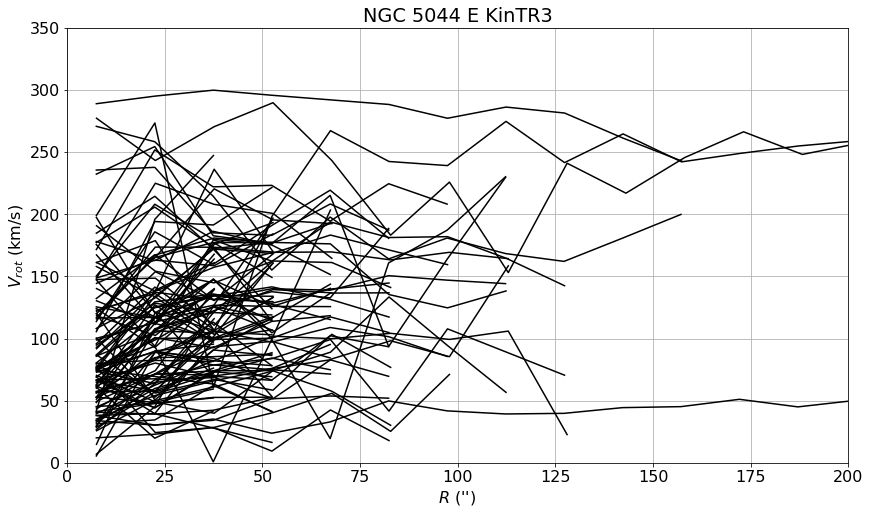

In [24]:
%matplotlib inline

#To make the plot look a bit nicer, we'll set the figure size and font size
plt.rcParams["figure.figsize"] = (14, 8)
plt.rcParams["font.size"] = 16

for row in kin_table_3kidnas:
    r=StrToArr_3kidnas(row['rad'])
    v = StrToArr_3kidnas(row['vrot_model'])
    plt.plot(r, v, ls='-', color='k', marker='')
    
plt.title(kin_tag)
plt.xlabel(r"$R$ ('') ")
plt.ylabel(r"$V_{rot}$ (km/s)")
plt.xlim(0.0, 200)
plt.ylim(0, 350)
plt.grid(True)
plt.show()

The 3KIDNAS models also include estimates for R_HI and V_HI for a subset of galaxies.  These are indicated by when the rhi_flag==0.  These are calculated both in arcseconds and in kpc, and should already account for beam smearing.  However, it is very important to note that the kpc value is based on the dist_model value.  That distance is derived from a basic Hubble flow with H0=70 km/s/Mpc.  For detailed analysis, we strongly recommend rederiving the distances using some flow model (that wasn't derived with WALLABY values).  

With these caveats in mind, we can quickly plot the size-velocity scaling relation.

/opt/homebrew/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3199: UserWarning: Warning: converting a masked element to nan.
  return asarray(a).ndim
/opt/homebrew/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1061: UserWarning: Warning: converting a masked element to nan.
  x = np.asanyarray(x)
/opt/homebrew/lib/python3.9/site-packages/matplotlib/axes/_base.py:2287: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


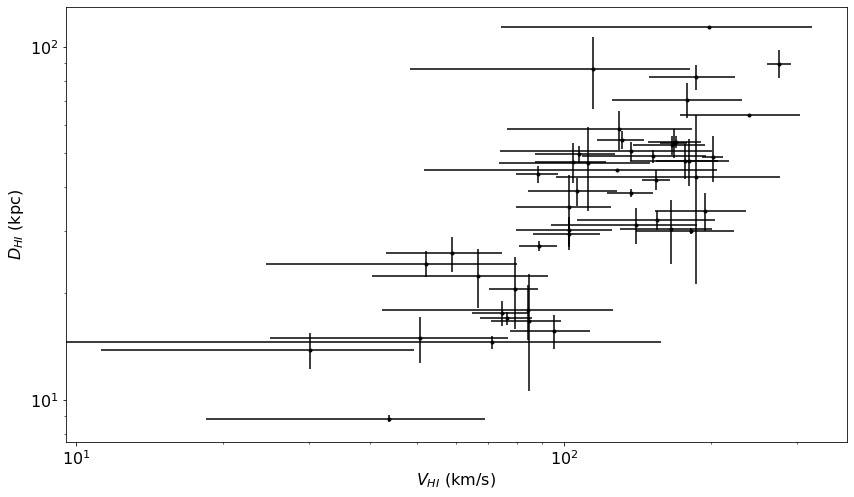

In [25]:
%matplotlib inline

#To make the plot look a bit nicer, we'll set the figure size and font size
plt.rcParams["figure.figsize"] = (14, 8)
plt.rcParams["font.size"] = 16
fig=plt.figure()
ax = fig.add_subplot(1, 1, 1)

for row in kin_table_3kidnas:
    if row['rhi_flag']==0:
        DHI=2*row['rhi_kpc']
        DHI_Low=2*row['rhi_low_kpc']
        DHI_High=2*row['rhi_high_kpc']
        DHI_Err=[[DHI-DHI_Low],[DHI_High-DHI]]
        VHI=row['vhi']
        VHI_Err=row['e_vhi']
        
        ax.errorbar(VHI, DHI, xerr=VHI_Err, yerr=DHI_Err, ls='', color='k', marker='.')
    
#plt.title(kin_tag)
ax.set_xlabel(r"$V_{HI}$ (km/s) ")
ax.set_ylabel(r"$D_{HI}$ (kpc)")
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

It is possible to compare WKAPP models to 3KIDNAS models for the PDR fields.  This won't be possible for the full survey as WKAPP will be replaced by 3KIDNAS.

In [ ]:
from astropy.table import join

#   First we will make a combined table that is matched on the name
TestTable=join(kin_table,kin_table_3kidnas,keys_left='name',keys_right='source_name')


#   Now we will initialize the figure
%matplotlib inline

#To make the plot look a bit nicer, we'll set the figure size and font size
plt.rcParams["figure.figsize"] = (14, 8)
plt.rcParams["font.size"] = 16
fig=plt.figure()
ax = fig.add_subplot(1, 1, 1)

#   Next we select which galaxy we want to plot -- in this case, it will be the first one in the combined 
GalIndx=0
#   For keys in each table with the same name (i.e. the RC keys), they are labelled 
#    with a _1 or _2 depending on which table they were drawn from.
#      Loop through both WKAPP and 3KIDNAS
for i in range(2):
        #  Set the keywords for the RC curve, using the _1 and _2 convention
        RKey='rad_'+str(i+1)
        VKey='vrot_model_'+str(i+1)
        VErrKey='e_vrot_model_'+str(i+1)
        #   Set the label -- note this is based on the order of the join
        if i==0:
            Label='WKAPP'
        elif i==1:
            Label='3KIDNAS'
        #    Get the radius, velocity and uncertainties.
        R=StrToArr_3kidnas(TestTable[RKey][GalIndx])
        V=StrToArr_3kidnas(TestTable[VKey][GalIndx])
        VErr=StrToArr_3kidnas(TestTable[VErrKey][GalIndx])
        #     Plot the RC for WKAPP and 3KIDNAS
        ax.errorbar(R, V, yerr=VErr, ls='-', marker='.',label=Label)

#    Format the plot
PltTitle=TestTable['name'][GalIndx]
plt.title(PltTitle)
ax.set_xlabel(r"$R$ ('') ")
ax.set_ylabel(r"$V$ (km/s)")
ax.legend()
plt.show()

